In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

billing = pd.read_csv("C:/Users/udin0/Downloads/Dataset-20250912T062612Z-1-001/Dataset/billing.csv")
events = pd.read_csv("C:/Users/udin0/Downloads/Dataset-20250912T062612Z-1-001/Dataset/events.csv")
sessions = pd.read_csv("C:/Users/udin0/Downloads/Dataset-20250912T062612Z-1-001/Dataset/sessions.csv")
users = pd.read_csv("C:/Users/udin0/Downloads/Dataset-20250912T062612Z-1-001/Dataset/users.csv")

# ------------------------
# 1️⃣ Sessions summary
# ------------------------
sessions_summary = sessions.groupby("user_id").agg(
    total_sessions=("session_length_sec", "count"),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique"),
    country_diversity=("country", "nunique"),
    avg_session_length_sec=("session_length_sec", "mean")
).reset_index()

# ------------------------
# 2️⃣ Events summary
# ------------------------
events_summary = events.groupby("user_id").agg(
    total_events=("feature_name", "count"),
    distinct_features=("feature_name", "nunique"),
    distinct_action=("action", "nunique"),
    avg_event_duration_ms=("duration_ms", "mean"),
    avg_latency_ms=("latency_ms", "mean"),
    success_rate=("success", "mean")
).reset_index()

# ------------------------
# 3️⃣ Billing summary
# ------------------------
def most_common(x):
    return x.value_counts().idxmax()

billing_summary = billing.groupby("user_id").agg(
    avg_mrr=("mrr", "mean"),
    total_active_seats=("active_seats", "sum"),
    discount_count=("discount_applied", "sum"),
    overdue_count=("invoices_overdue", "sum"),
    avg_support_tickets=("support_ticket_count", "mean"),
    most_common_plan=("plan_tier", most_common)
).reset_index()

# ------------------------
# 4️⃣ Merge all summaries
# ------------------------
merged_data = users.merge(sessions_summary, on="user_id", how="left") \
                   .merge(events_summary, on="user_id", how="left") \
                   .merge(billing_summary, on="user_id", how="left")

# ------------------------
# 5️⃣ Handle missing values
# ------------------------
# Separate numeric and categorical columns
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = merged_data.select_dtypes(include=["object", "category"]).columns.tolist()

# # Impute numeric columns with median
# for col in numeric_cols:
#     merged_data[col] = merged_data[col].fillna(merged_data[col].median())

# # Impute categorical columns with mode
# for col in cat_cols:
#     merged_data[col] = merged_data[col].fillna(merged_data[col].mode()[0])

# ------------------------
# 6️⃣ Drop unwanted columns
# ------------------------
drop_cols = ["user_id", "signup_date", "plan_tier", "company_size",
             "region", "industry", "acquisition_channel", "churned_90d"]

merged_data = merged_data.drop(columns=[col for col in drop_cols if col in merged_data.columns])

# Check for remaining missing values
print(merged_data.isna().sum())

is_enterprise                 0
churned_30d                   0
downgraded                    0
expansion_event               0
total_sessions            28467
device_diversity          28467
os_diversity              28467
country_diversity         28467
avg_session_length_sec    28467
total_events              42688
distinct_features         42688
distinct_action           42688
avg_event_duration_ms     42688
avg_latency_ms            42688
success_rate              42688
avg_mrr                       0
total_active_seats            0
discount_count                0
overdue_count                 0
avg_support_tickets           0
most_common_plan              0
dtype: int64


In [2]:
import pandas as pd

# Select only numeric columns
numeric_cols = merged_data.select_dtypes(include='number').columns
numeric_data = merged_data[numeric_cols]

# Compute correlation matrix
corr_matrix = numeric_data.corr()

print(corr_matrix)

                        churned_30d  downgraded  expansion_event  \
churned_30d                1.000000   -0.018441         0.038401   
downgraded                -0.018441    1.000000        -0.004177   
expansion_event            0.038401   -0.004177         1.000000   
total_sessions            -0.095180    0.119443        -0.061016   
device_diversity          -0.090489    0.114497        -0.067256   
os_diversity              -0.098627    0.122924        -0.066740   
country_diversity         -0.081381    0.100373        -0.058630   
avg_session_length_sec    -0.000238   -0.003863         0.001930   
total_events              -0.083371    0.093017        -0.043185   
distinct_features         -0.078923    0.084897        -0.038510   
distinct_action           -0.079393    0.083293        -0.039261   
avg_event_duration_ms     -0.005076    0.003968         0.003180   
avg_latency_ms             0.023636   -0.005122         0.003387   
success_rate              -0.002745   -0.001321 

In [3]:
# Threshold for high correlation
threshold = 0.8

# Find pairs
high_corr = (corr_matrix.abs() > threshold) & (corr_matrix.abs() < 1)
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns
                   for col2 in corr_matrix.columns
                   if high_corr.loc[col1, col2]]

print("Highly correlated pairs (>0.8):")
for pair in high_corr_pairs:
    print(pair)


Highly correlated pairs (>0.8):
('total_sessions', 'os_diversity', np.float64(0.8288077467880106))
('total_sessions', 'total_events', np.float64(0.8629328168431798))
('device_diversity', 'os_diversity', np.float64(0.8636089769500622))
('os_diversity', 'total_sessions', np.float64(0.8288077467880106))
('os_diversity', 'device_diversity', np.float64(0.8636089769500622))
('total_events', 'total_sessions', np.float64(0.8629328168431798))
('avg_mrr', 'avg_support_tickets', np.float64(0.9499241958069156))
('total_active_seats', 'avg_support_tickets', np.float64(0.8310869731272463))
('avg_support_tickets', 'avg_mrr', np.float64(0.9499241958069156))
('avg_support_tickets', 'total_active_seats', np.float64(0.8310869731272463))


In [23]:
merged_data = merged_data.drop(["total_sessions","device_diversity", "avg_session_length_sec", "country_diversity","success_rate"], axis=1)
print(merged_data.columns)

Index(['is_enterprise', 'churned_30d', 'downgraded', 'expansion_event',
       'os_diversity', 'total_events', 'distinct_features', 'distinct_action',
       'avg_event_duration_ms', 'avg_latency_ms', 'avg_mrr',
       'total_active_seats', 'discount_count', 'overdue_count',
       'avg_support_tickets', 'most_common_plan'],
      dtype='object')


In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Example dataset
X = merged_data.drop("churned_30d", axis=1)
y = merged_data["churned_30d"]

# Encode categorical columns if needed
for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [6]:
import pandas as pd

importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importance_df)


                  feature  importance
14       most_common_plan    0.191882
9                 avg_mrr    0.176154
6         distinct_action    0.083664
8          avg_latency_ms    0.054279
3            os_diversity    0.052760
4            total_events    0.051749
10     total_active_seats    0.051021
7   avg_event_duration_ms    0.048054
2         expansion_event    0.047444
5       distinct_features    0.046981
12          overdue_count    0.044113
13    avg_support_tickets    0.044033
11         discount_count    0.040978
0           is_enterprise    0.040528
1              downgraded    0.026360


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


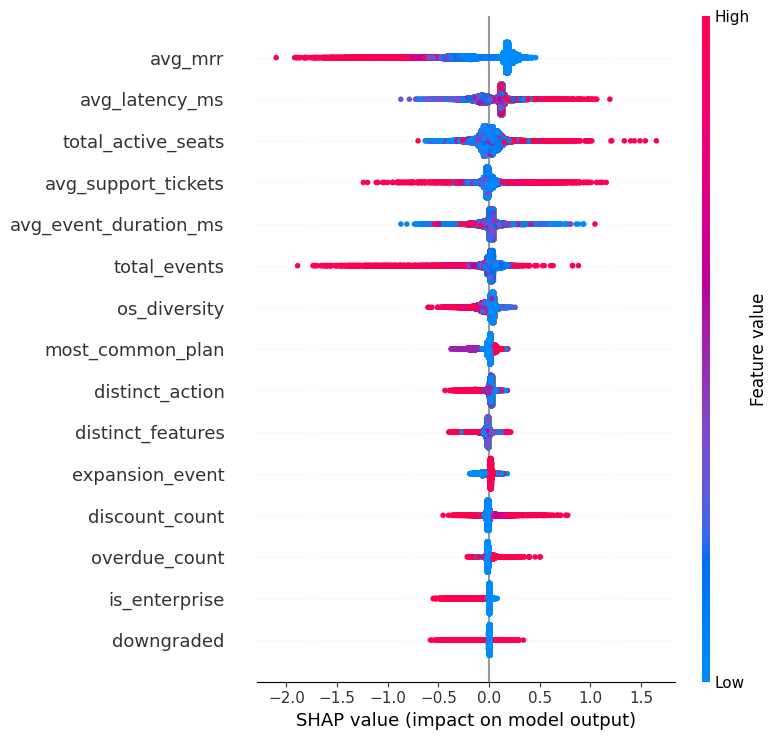

In [7]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [8]:
# Identify categorical & numerical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Logistic Regression model
log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight=None
)

# Pipeline with SMOTEENN
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smoteenn", SMOTEENN(random_state=42)),
    ("model", log_reg)
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated probabilities
y_pred_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')

# Apply custom threshold 0.3
threshold = 0.5
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

# Compute F1 score
f1 = f1_score(y, y_pred)
print("Overall F1 score:", f1)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
print("\nConfusion Matrix:\n", cm)

# Detailed metrics
print("\nClassification Report:\n", classification_report(y, y_pred))

Categorical columns: []
Numeric columns: ['downgraded', 'expansion_event', 'os_diversity', 'total_events', 'distinct_features', 'distinct_action', 'avg_event_duration_ms', 'avg_latency_ms', 'avg_mrr', 'total_active_seats', 'discount_count', 'overdue_count', 'avg_support_tickets', 'most_common_plan']
Overall F1 score: 0.22511450130152558

Confusion Matrix:
 [[46134 40905]
 [ 6129  6832]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.53      0.66     87039
           1       0.14      0.53      0.23     12961

    accuracy                           0.53    100000
   macro avg       0.51      0.53      0.44    100000
weighted avg       0.79      0.53      0.61    100000



In [24]:
# Check for remaining missing values
print(merged_data.isna().sum())

is_enterprise                0
churned_30d                  0
downgraded                   0
expansion_event              0
os_diversity             28467
total_events             42688
distinct_features        42688
distinct_action          42688
avg_event_duration_ms    42688
avg_latency_ms           42688
avg_mrr                      0
total_active_seats           0
discount_count               0
overdue_count                0
avg_support_tickets          0
most_common_plan             0
dtype: int64


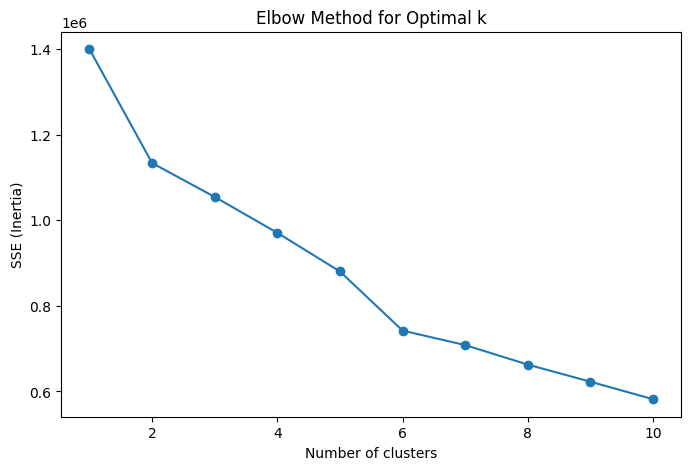

cluster
2    63653
0    30804
1     5543
Name: count, dtype: int64


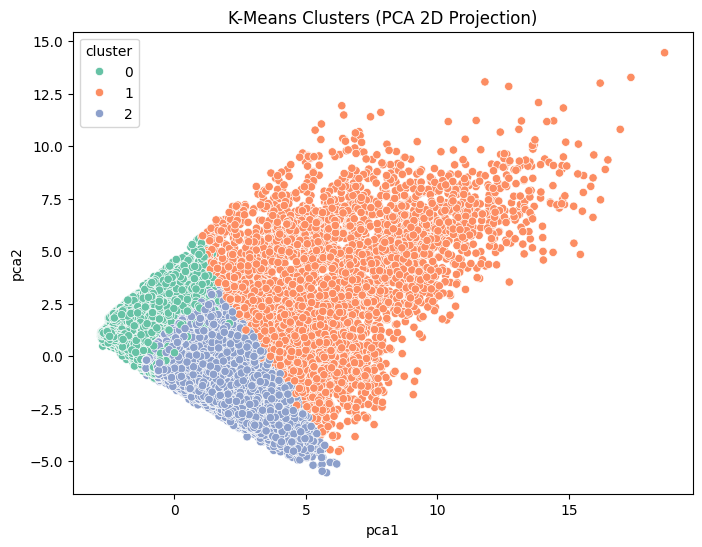

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Create a copy for clustering (so original data remains unchanged)
cluster_data = merged_data.copy()

# Identify numeric and categorical columns
numeric_cols = cluster_data.select_dtypes(include=np.number).columns.tolist()
categorical_cols = cluster_data.select_dtypes(include=["object", "category"]).columns.tolist()

# Impute missing values on the copy
# Numeric: mean
cluster_data[numeric_cols] = cluster_data[numeric_cols].fillna(cluster_data[numeric_cols].mean())

# Categorical: mode
for col in categorical_cols:
    mode_val = cluster_data[col].mode()[0]
    cluster_data[col] = cluster_data[col].fillna(mode_val)

# Select numeric columns only for clustering
X = cluster_data[numeric_cols]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # Sum of squared distances

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

# Fit K-Means with chosen number of clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(X_scaled)

# Check cluster counts
print(cluster_data['cluster'].value_counts())

# Optional: visualize clusters using first two principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
cluster_data['pca1'] = X_pca[:, 0]
cluster_data['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=cluster_data, palette='Set2')
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.show()


In [54]:
# Define target column
target_col = 'churned_30d'  # replace with your actual target column

# Loop over clusters and check value counts
for cluster_label in [0, 1, 2]:
    checkcluster = cluster_data[cluster_data['cluster'] == cluster_label]
    y_cluster = checkcluster[target_col]
    
    print(f"\nCluster {cluster_label} target distribution:")
    print(y_cluster.value_counts())
    print("Percentage distribution:")
    print(round(y_cluster.value_counts(normalize=True) * 100, 2))


Cluster 0 target distribution:
churned_30d
0    19669
1    11135
Name: count, dtype: int64
Percentage distribution:
churned_30d
0    63.85
1    36.15
Name: proportion, dtype: float64

Cluster 1 target distribution:
churned_30d
0    5199
1     344
Name: count, dtype: int64
Percentage distribution:
churned_30d
0    93.79
1     6.21
Name: proportion, dtype: float64

Cluster 2 target distribution:
churned_30d
0    62171
1     1482
Name: count, dtype: int64
Percentage distribution:
churned_30d
0    97.67
1     2.33
Name: proportion, dtype: float64



Cluster 0 - Numeric feature summary:
                         count        mean         std   min         25%  \
churned_30d            30804.0    0.361479    0.480437   0.0    0.000000   
downgraded             30804.0    0.011427    0.106287   0.0    0.000000   
expansion_event        30804.0    0.710849    0.453375   0.0    0.000000   
os_diversity           30804.0    1.907278    0.892070   1.0    1.000000   
total_events           30804.0    2.076164    1.259661   1.0    1.000000   
distinct_features      30804.0    1.370137    0.501348   1.0    1.000000   
distinct_action        30804.0    1.369442    0.481009   1.0    1.000000   
avg_event_duration_ms  30804.0  974.206398  898.537488   6.0  465.458333   
avg_latency_ms         30804.0  261.110565  248.709717  10.0  155.000000   
avg_mrr                30804.0   70.945839  197.470557   0.0    0.000000   
total_active_seats     30804.0  149.342942  252.585761   2.0   25.000000   
discount_count         30804.0    0.400954    0.86

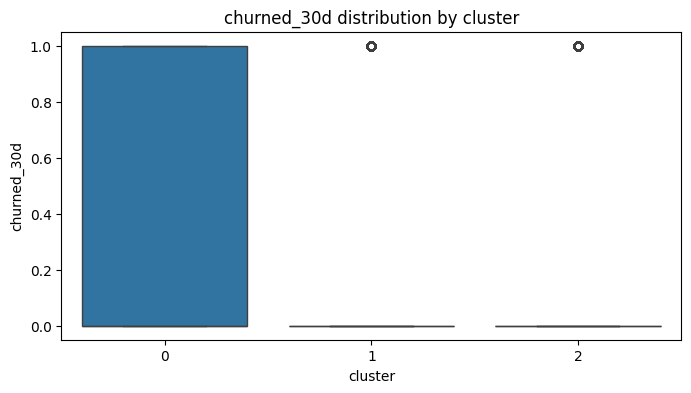

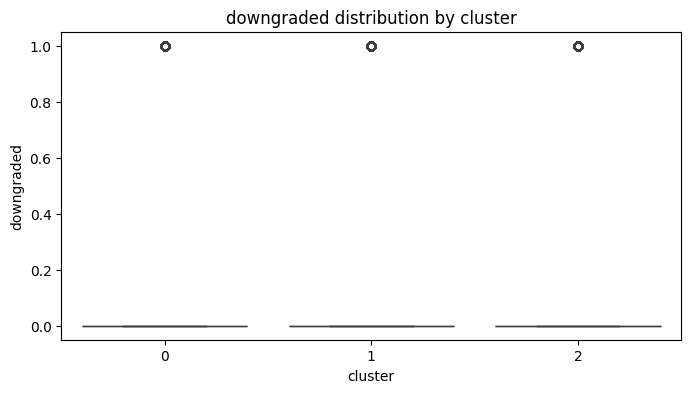

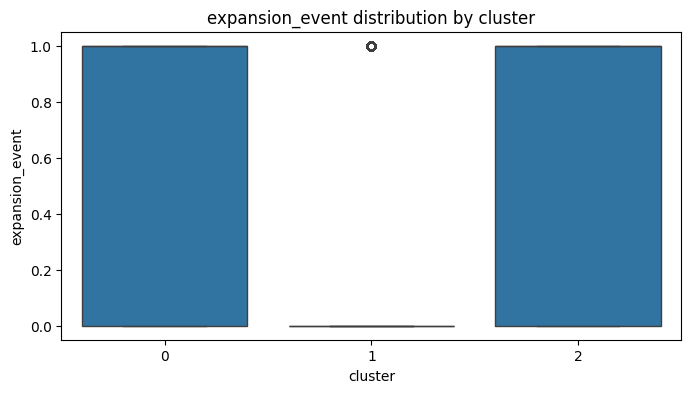

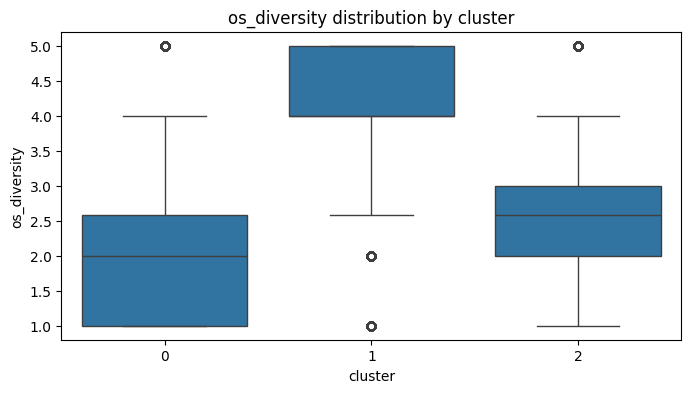

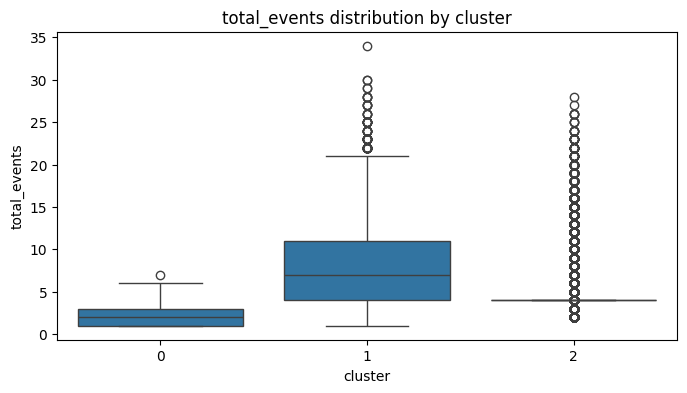

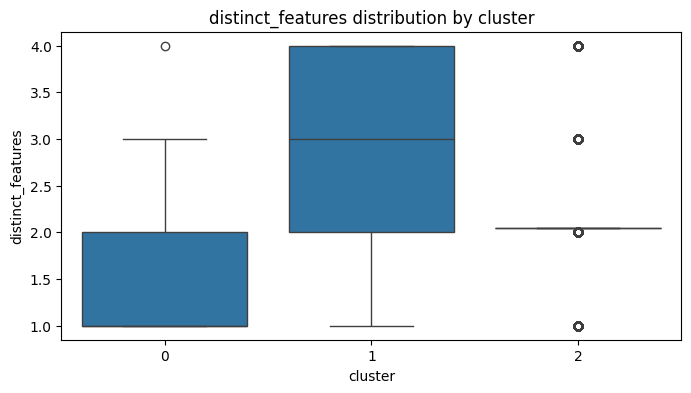

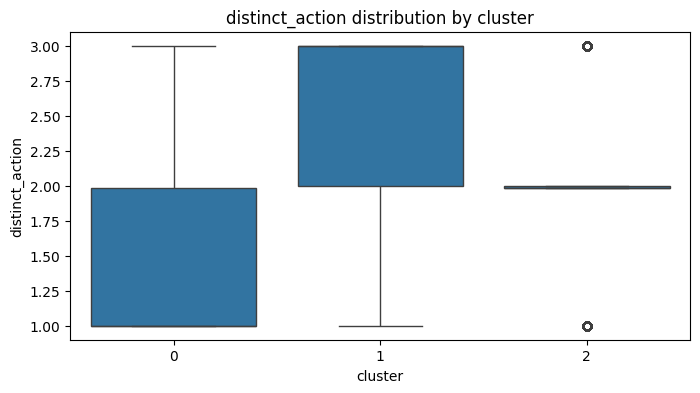

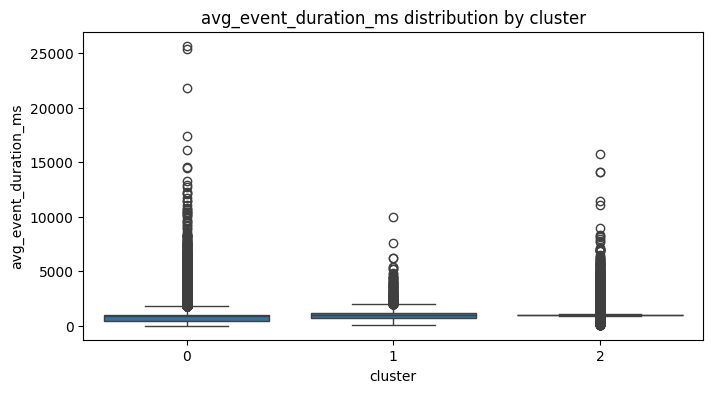

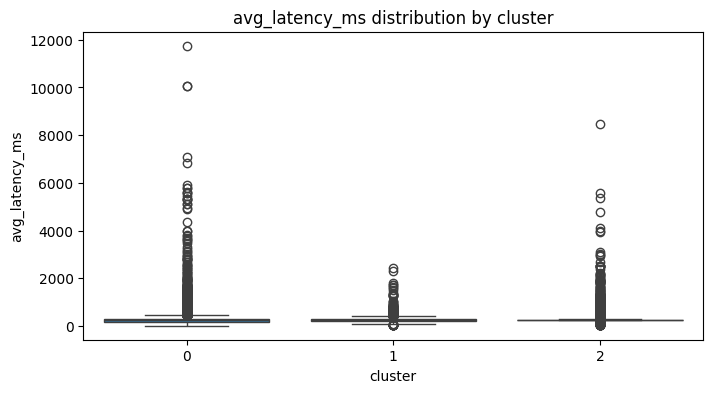

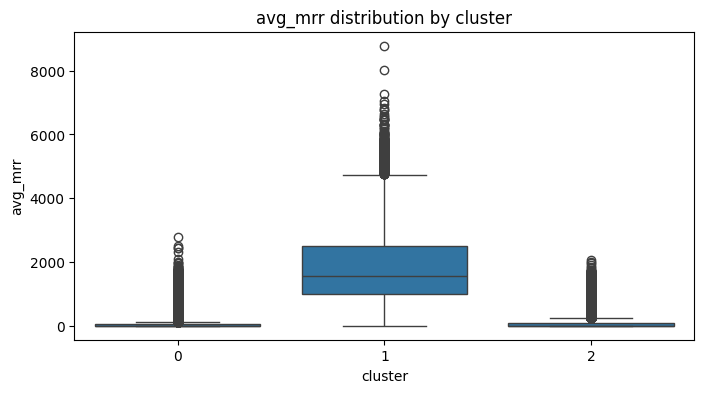

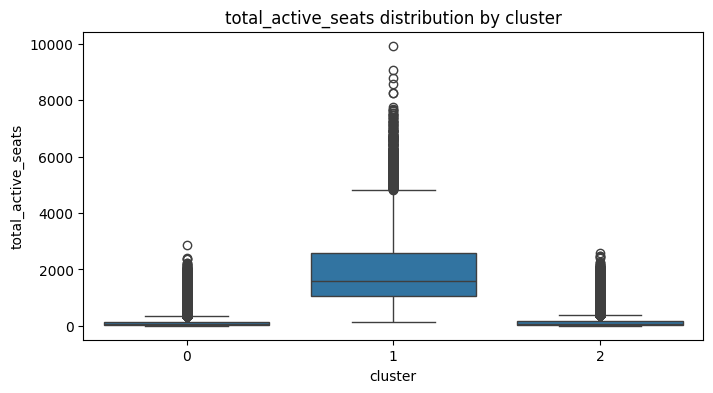

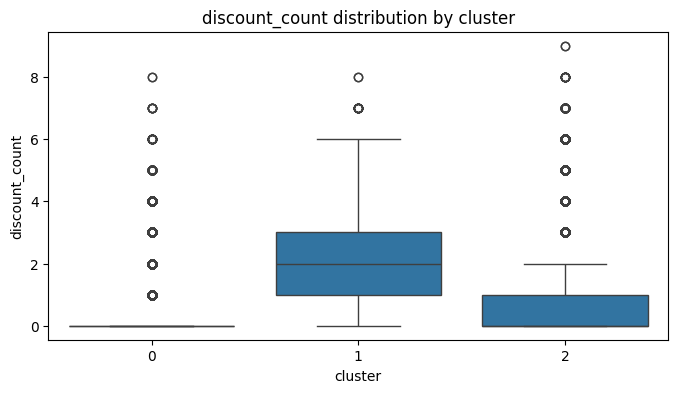

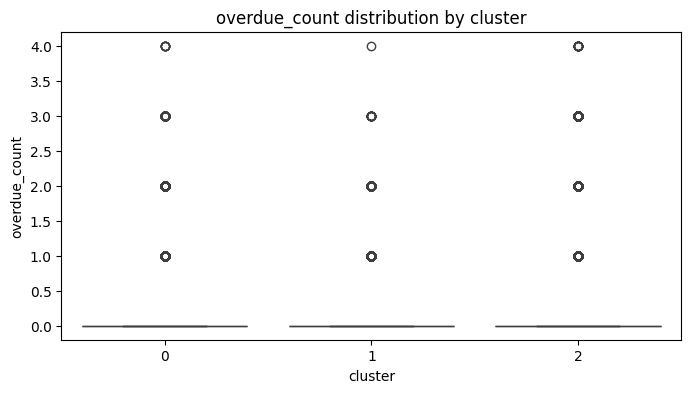

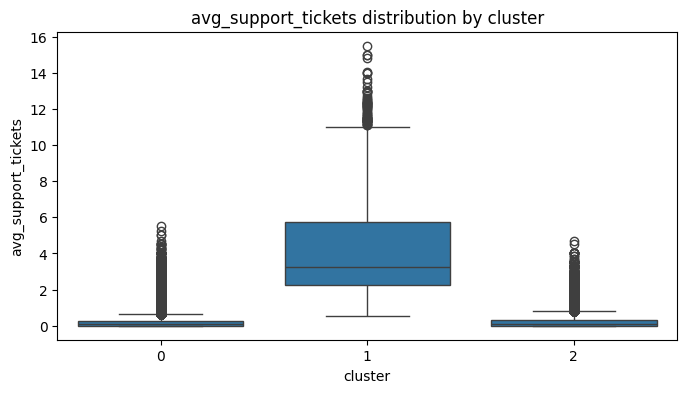

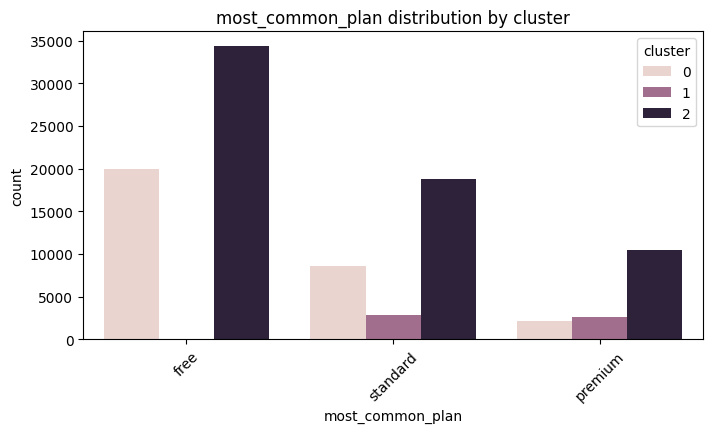

In [55]:
# Numeric features
for cluster_label in [0, 1, 2]:
    model_cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    print(f"\nCluster {cluster_label} - Numeric feature summary:")
    print(model_cluster[numeric_cols].describe().T)  # mean, std, min, max, etc.

# Categorical features
for cluster_label in [0, 1, 2]:
    model_cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    print(f"\nCluster {cluster_label} - Categorical feature distribution:")
    for col in categorical_cols:
        print(f"\nFeature: {col}")
        print(model_cluster[col].value_counts())

import matplotlib.pyplot as plt
import seaborn as sns

# Histograms or boxplots for numeric features
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='cluster', y=col, data=cluster_data)
    plt.title(f"{col} distribution by cluster")
    plt.show()

# Barplots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='cluster', data=cluster_data)
    plt.title(f"{col} distribution by cluster")
    plt.xticks(rotation=45)
    plt.show()

In [56]:
# Define target column
target_col = 'churned_30d'  # replace with your actual target column

# Dictionary to store models and metrics
cluster_models = {}
cluster_metrics = {}

# Loop over the two clusters
for cluster_label in [0, 1, 2]:
    print(f"\nProcessing cluster {cluster_label}...")
    
    # Select data for this cluster
    final_cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    X_cluster = final_cluster.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
    y_cluster = final_cluster[target_col]
    
    # Identify categorical & numerical columns
    categorical_cols = X_cluster.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols = X_cluster.select_dtypes(include=["int64", "float64"]).columns.tolist()
    
    # Preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])
    
    # Logistic Regression model
    log_reg = LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        class_weight="balanced"  # handle imbalanced data
    )
    
    # Full pipeline with SMOTEENN
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("smoteenn", SMOTEENN(random_state=42)),
        ("model", log_reg)
    ])
    
    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Get cross-validated probabilities
    y_pred_proba = cross_val_predict(pipeline, X_cluster, y_cluster, cv=cv, method='predict_proba')
    
    # Apply custom threshold
    threshold = 0.5
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    
    # Compute metrics
    f1 = f1_score(y_cluster, y_pred)
    cm = confusion_matrix(y_cluster, y_pred)
    report = classification_report(y_cluster, y_pred)
    
    print(f"\nCluster {cluster_label} F1 Score: {f1}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    
    # Save pipeline and metrics
    cluster_models[cluster_label] = pipeline
    cluster_metrics[cluster_label] = {"f1": f1, "cm": cm, "report": report}

print("\nLogistic Regression pipelines trained for both clusters!")



Processing cluster 0...

Cluster 0 F1 Score: 0.7946540577052977
Confusion Matrix:
 [[18313  1356]
 [ 2900  8235]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.90     19669
           1       0.86      0.74      0.79     11135

    accuracy                           0.86     30804
   macro avg       0.86      0.84      0.85     30804
weighted avg       0.86      0.86      0.86     30804


Processing cluster 1...

Cluster 1 F1 Score: 0.13821138211382114
Confusion Matrix:
 [[2795 2404]
 [ 140  204]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.54      0.69      5199
           1       0.08      0.59      0.14       344

    accuracy                           0.54      5543
   macro avg       0.52      0.57      0.41      5543
weighted avg       0.90      0.54      0.65      5543


Processing cluster 2...

Cluster 2 F1 Score: 0.1381037956760878
Confus

In [62]:
# Select cluster 0
cluster_0_data = cluster_data[cluster_data['cluster'] == 0]

# Define features and target
target_col = 'churned_30d'
X = cluster_0_data.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
y = cluster_0_data[target_col]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Logistic Regression model
log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced"
)

# Full pipeline with SMOTEENN
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smoteenn", SMOTEENN(random_state=42)),
    ("model", log_reg)
])

# Fit pipeline on cluster 0
pipeline.fit(X, y)

# Extract feature names after preprocessing
feature_names_num = numeric_cols
if categorical_cols:
    feature_names_cat = pipeline.named_steps['preprocessor'] \
        .named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
    feature_names = list(feature_names_num) + list(feature_names_cat)
else:
    feature_names = feature_names_num

# Get logistic regression coefficients
coefficients = pipeline.named_steps['model'].coef_[0]

# Create a DataFrame to display feature importance
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort by absolute value of coefficient
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coef', ascending=False)

print("Top features by coefficient magnitude for cluster 0:")
print(coef_df_sorted[['feature', 'coefficient']].head(10))

Top features by coefficient magnitude for cluster 0:
                      feature  coefficient
3                total_events     1.544486
14   most_common_plan_premium    -1.393783
4           distinct_features     0.924809
5             distinct_action     0.668047
2                os_diversity     0.403530
15  most_common_plan_standard    -0.396265
13      most_common_plan_free     0.330755
9          total_active_seats    -0.217035
7              avg_latency_ms     0.195799
10             discount_count     0.184540


In [59]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

column_model =  cluster_data[cluster_data['cluster'] == 0]

# Example dataset
Xcm = column_model.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
ycm = column_model["churned_30d"]

# Encode categorical columns if needed
for col in Xcm.select_dtypes(include="object").columns:
    Xcm[col] = LabelEncoder().fit_transform(Xcm[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(Xcm, ycm, test_size=0.2, random_state=42)

# XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:58:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

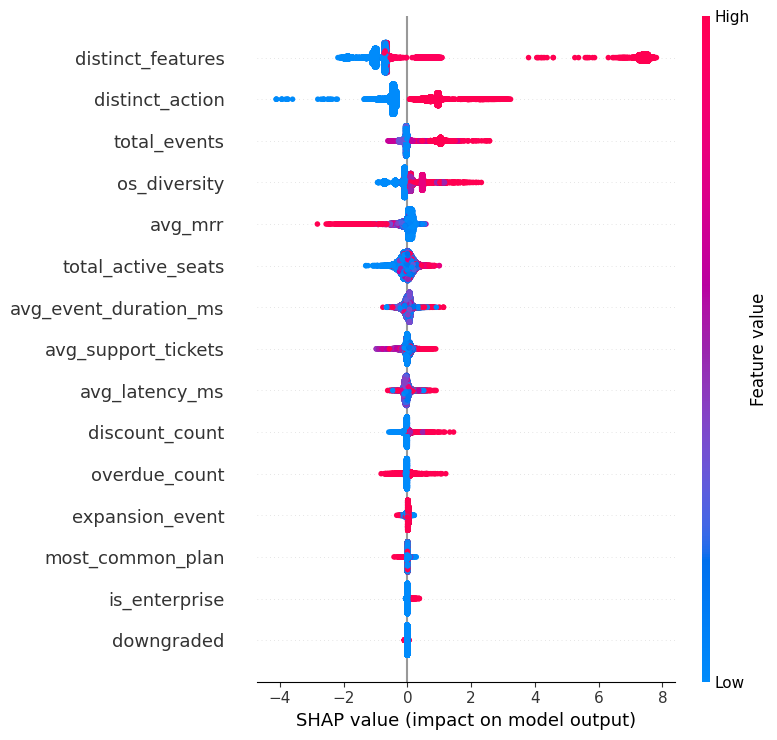

In [60]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [61]:
# List of features to calculate mean
features_to_check = [
    'distinct_features',
    'distinct_action',
    'total_events',
    'os_diversity',
    'avg_mrr'
]

# Group by cluster and calculate mean for selected features
cluster_means = cluster_data.groupby('cluster')[features_to_check].mean()

# Display results
print(cluster_means)

         distinct_features  distinct_action  total_events  os_diversity  \
cluster                                                                   
0                 1.370137         1.369442      2.076164      1.907278   
1                 2.907547         2.639389      8.158859      4.170320   
2                 2.301439         2.218797      4.708133      2.774509   

             avg_mrr  
cluster               
0          70.945839  
1        1923.497461  
2          90.461755  



Processing cluster 0...


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


Cluster 0 F1 Score: 0.8379054970272244
Confusion Matrix:
 [[19663     6]
 [ 3102  8033]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93     19669
           1       1.00      0.72      0.84     11135

    accuracy                           0.90     30804
   macro avg       0.93      0.86      0.88     30804
weighted avg       0.91      0.90      0.89     30804


Processing cluster 1...


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


Cluster 1 F1 Score: 0.0
Confusion Matrix:
 [[5197    2]
 [ 344    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      5199
           1       0.00      0.00      0.00       344

    accuracy                           0.94      5543
   macro avg       0.47      0.50      0.48      5543
weighted avg       0.88      0.94      0.91      5543


Processing cluster 2...


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


Cluster 2 F1 Score: 0.0
Confusion Matrix:
 [[62170     1]
 [ 1482     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     62171
           1       0.00      0.00      0.00      1482

    accuracy                           0.98     63653
   macro avg       0.49      0.50      0.49     63653
weighted avg       0.95      0.98      0.97     63653


Computing SHAP values for cluster 0...


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


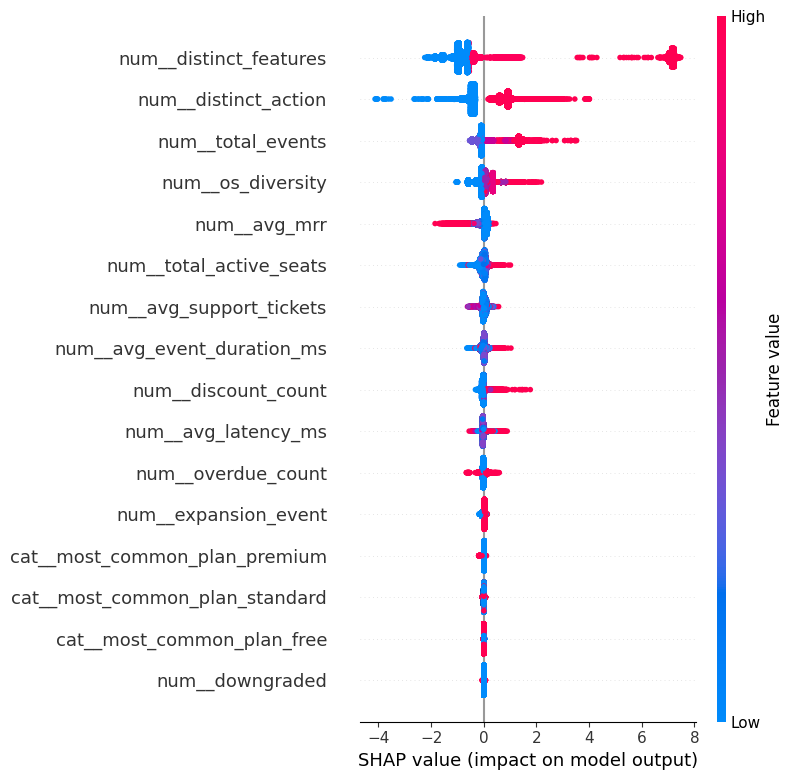

In [65]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Dictionary to store models and metrics
cluster_models = {}
cluster_metrics = {}

# Define target column
target_col = 'churned_30d'

# Loop over clusters
for cluster_label in [0, 1, 2]:
    print(f"\nProcessing cluster {cluster_label}...")
    
    # Select data for this cluster
    final_cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    X_cluster = final_cluster.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
    y_cluster = final_cluster[target_col]
    
    # Identify categorical & numerical columns
    categorical_cols = X_cluster.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols = X_cluster.select_dtypes(include=["int64", "float64"]).columns.tolist()
    
    # Preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])
    
    # XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42
    )
    
    # Full pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_model)
    ])
    
    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Get cross-validated probabilities
    y_pred_proba = cross_val_predict(pipeline, X_cluster, y_cluster, cv=cv, method='predict_proba')
    
    # Apply threshold
    threshold = 0.5
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    
    # Compute metrics
    f1 = f1_score(y_cluster, y_pred)
    cm = confusion_matrix(y_cluster, y_pred)
    report = classification_report(y_cluster, y_pred)
    
    print(f"\nCluster {cluster_label} F1 Score: {f1}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    
    # Save pipeline and metrics
    cluster_models[cluster_label] = pipeline
    cluster_metrics[cluster_label] = {"f1": f1, "cm": cm, "report": report}

# -----------------------------
# SHAP for cluster 0 only
# -----------------------------
print("\nComputing SHAP values for cluster 0...")

cluster_0_data = cluster_data[cluster_data['cluster'] == 0]
X0 = cluster_0_data.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
y0 = cluster_0_data[target_col]

# Fit pipeline on cluster 0
pipeline_0 = cluster_models[0]
pipeline_0.fit(X0, y0)

# Extract preprocessed features
X0_preprocessed = pipeline_0.named_steps['preprocessor'].transform(X0)

# SHAP explainer
explainer = shap.Explainer(pipeline_0.named_steps['model'])
shap_values = explainer(X0_preprocessed)

# Plot summary
shap.summary_plot(shap_values, X0_preprocessed, feature_names=pipeline_0.named_steps['preprocessor'].get_feature_names_out())
